## Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import os

%matplotlib inline

In [2]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

In [3]:
# Show more columns without truncation
pd.set_option('display.max_columns', None)

# Show more rows
pd.set_option('display.max_rows', None)

# Increase column width
pd.set_option('display.max_colwidth', 100)

In [4]:
sns.set_theme('notebook')
warnings.filterwarnings("ignore")

## Research Questions

#### 1. How does GDP per capita relate to tertiary education attainment?

#### 2. Is there a correlation between GDP per capita and greenhouse gas emissions?

#### 3. How does tertiary education attainment correlate with unemployment rate?

## Analysis

### Utils

In [5]:
# Dictionary for specifying aggregation methods for yearly data
agg_dict_yearly = {
    'gdp_quarterly': 'sum',
    'gdp': 'first',                         
    'inflation_rate_annual': 'first',      
    'education_attainment': 'first',        
    'gdp_per_capita': 'first',
    'gdp_growth_rate': 'first',
    'gdp_growth_rate_quarterly':'mean',
    'price_index': 'last',                  # take last month of year
    'energy_prices': 'mean',                # average if multiple months
    'gas_emissions': 'first',
    'household_income_q1': 'first',
    'household_income_q2': 'first',
    'household_income_q3': 'first',
    'household_income': 'first',
    'net_migration': 'first',
    'total_population': 'first',
    'net_population_growth': 'first',
    'growth_rate': 'first',
    'births': 'first',
    'deaths': 'first',
    'inflation_rate_monthly_y': lambda x: x.mean().round(1) if len(x) == 12 else np.nan,
    'total_unemployment_rate': 'mean',      # average monthly unemployment
    'adult_unemployment_rate': 'mean',
    'youth_unemployment_rate': 'mean',
    'unemployment_rate_annual': 'first'
}

drop_list_yearly = [
    'inflation_rate_monthly_m',
    'inflation_rate_annual'
]

rename_dict_cols = {
    'inflation_rate_monthly_y': 'inflation_rate'
}

In [6]:
def aggregate_data_on_frequency(raw_df: pd.DataFrame, frequency: str = 'Y') -> pd.DataFrame:
    """Aggregate data on a specified frequency.

    Args:
        raw_df (pd.DataFrame): The raw data to aggregate.
        frequency (str, optional): The frequency to aggregate on. Defaults to 'Y'.

    Returns:
        pd.DataFrame: The aggregated data.
    """   
    
    df = raw_df.copy()
    df['TIME_PERIOD'] = pd.to_datetime(df['TIME_PERIOD'], errors='coerce')
    
    aggregate_df = pd.DataFrame()
    
    if frequency == 'Y':
        df['year'] = df['TIME_PERIOD'].dt.year

        # Perform aggregation by year using the aggregation dictionary
        aggregate_df = df.groupby('year').agg(agg_dict_yearly).reset_index()
        aggregate_df['TIME_PERIOD'] = pd.to_datetime(aggregate_df['year'].astype(str))
        aggregate_df = aggregate_df.drop(columns='year')
        
    aggregate_df = aggregate_df.drop(columns=[col for col in drop_list_yearly if col in aggregate_df.columns])
    
    aggregate_df = aggregate_df.rename(
        columns={old: new for old, new in rename_dict_cols.items() if old in aggregate_df.columns}
    )
    
    # Add the TIME_PERIOD column at the front of the DataFrame
    cols = list(aggregate_df.columns)
    cols.insert(0, cols.pop(cols.index('TIME_PERIOD')))
    aggregate_df = aggregate_df.loc[:, cols]
    
    return aggregate_df

In [7]:
def plot_dataframe(df: pd.DataFrame, n_cols: int = 4, plot: str = 'hist', comparison: str = 'TIME_PERIOD') -> None:
    """
    Plot the DataFrame with specified number of columns and plot type.

    Args:
        df (pd.DataFrame): The DataFrame to plot.
        n_cols (int, optional): The number of columns for the plot layout. Defaults to 4.
        plot (str, optional): The type of plot to create. Defaults to 'hist'.
        comparison (str, optional): The column to compare against. Defaults to 'TIME_PERIOD'.

    Returns:
        None
    """
    
    # Plot graph with subplots equal to number of numerical columns
    num_cols = df.select_dtypes(include='number').columns
    n_rows = int(len(num_cols) / n_cols) + 1

    plots = ['hist', 'box', 'line', 'scatter']
    
    if comparison not in df.columns:
        return print("Unknown feature column to compare with.")
    
    if plot not in plots:
        return print("Unknown plot option.")
    
    plt.figure(figsize=(20, 15))

    # Create subplots for each numerical column
    for i, col in enumerate(num_cols, 1):
        plt.subplot(n_rows, n_cols, i)
        
        if plot == 'hist':
            sns.histplot(data=df, x=col, kde=True)
        elif plot == 'box':
            sns.boxplot(data=df, x=col)
        elif plot == 'line':
            sns.lineplot(data=df, x=comparison, y=col)
        elif plot == 'scatter':
            sns.scatterplot(data=df, x=comparison, y=col)
        
        plt.title(col, fontsize=10)
        plt.tight_layout()

    plt.show()
    
    return None

### Dataset Analysis

In [8]:
FILE_PATH = "eurostat_data/sweden_eurostat_data.csv"
CLEAN_DF_PATH = "clean_data"

os.makedirs(CLEAN_DF_PATH, exist_ok=True)

In [9]:
df = pd.read_csv(FILE_PATH)

df.tail()

,TIME_PERIOD,gdp_quarterly,gdp,unemployment_rate_annual,inflation_rate_annual,education_attainment,gdp_per_capita,gdp_growth_rate,price_index,energy_prices,inflation_rate_monthly_m,inflation_rate_monthly_y,gas_emissions,household_income_q1,household_income_q2,household_income_q3,net_migration,total_population,net_population_growth,growth_rate,births,deaths,total_unemployment_rate,adult_unemployment_rate,youth_unemployment_rate
304,2025-05-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,131.96,NaN,0.3,2.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.1,6.9,25.0
305,2025-06-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,132.71,NaN,0.6,2.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.3,6.2,23.9
306,2025-07-01,120604.1,NaN,NaN,NaN,NaN,NaN,NaN,133.12,NaN,0.3,3.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.9,6.7,24.6
307,2025-08-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,132.69,NaN,-0.3,3.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.8,6.6,24.4
308,2025-09-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,132.90,NaN,0.2,3.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.7,6.7,23.6


In [10]:
df.info() # Correct data types

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309 entries, 0 to 308
Data columns (total 25 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   TIME_PERIOD               309 non-null    object 
 1   gdp_quarterly             103 non-null    float64
 2   gdp                       25 non-null     float64
 3   unemployment_rate_annual  12 non-null     float64
 4   inflation_rate_annual     12 non-null     float64
 5   education_attainment      25 non-null     float64
 6   gdp_per_capita            25 non-null     float64
 7   gdp_growth_rate           12 non-null     float64
 8   price_index               309 non-null    float64
 9   energy_prices             37 non-null     float64
 10  inflation_rate_monthly_m  309 non-null    float64
 11  inflation_rate_monthly_y  309 non-null    float64
 12  gas_emissions             24 non-null     float64
 13  household_income_q1       21 non-null     float64
 14  household_

In [11]:
df.describe() # Consistent data 

,gdp_quarterly,gdp,unemployment_rate_annual,inflation_rate_annual,education_attainment,gdp_per_capita,gdp_growth_rate,price_index,energy_prices,inflation_rate_monthly_m,inflation_rate_monthly_y,gas_emissions,household_income_q1,household_income_q2,household_income_q3,net_migration,total_population,net_population_growth,growth_rate,births,deaths,total_unemployment_rate,adult_unemployment_rate,youth_unemployment_rate
count,103.000000,25.000000,12.000000,12.000000,25.000000,25.000000,12.000000,309.000000,37.000000,309.000000,309.000000,24.000000,21.000000,21.000000,21.000000,25.000000,2.500000e+01,25.00000,25.000000,25.00000,25.000000,309.000000,309.000000,309.000000
mean,98224.544660,390477.644000,5.600000,2.283333,34.767500,40362.000000,1.783333,99.768350,0.168519,0.166990,2.027184,41.911029,16615.285714,23089.619048,30451.333333,53354.000000,9.626437e+06,69051.36000,7.124000,107652.76000,91955.400000,7.416181,5.645631,20.194175
std,13563.411291,53771.776196,0.596962,2.374805,7.209067,3176.974452,1.876570,13.790871,0.020821,0.483236,1.821687,6.969710,2111.023239,3412.198038,4953.777027,25221.262751,5.898073e+05,32946.55978,3.260787,8225.49297,2084.665501,1.001069,0.712656,3.752242
min,73909.700000,303735.800000,4.700000,0.200000,24.087500,34240.000000,-1.900000,78.830000,0.135145,-1.800000,-0.300000,30.435070,13211.000000,17329.000000,22286.000000,24386.000000,8.872109e+06,21366.00000,2.400000,90441.00000,88766.000000,4.900000,3.800000,9.600000
25%,88106.100000,352131.300000,5.075000,0.700000,28.912500,38060.000000,1.025000,88.410000,0.154708,-0.100000,1.100000,36.785877,14740.000000,20217.000000,26045.000000,28820.000000,9.080505e+06,36003.00000,4.000000,100928.00000,90532.000000,6.600000,5.100000,17.800000
50%,96332.300000,384163.200000,5.700000,1.800000,33.500000,40590.000000,1.850000,98.880000,0.167951,0.200000,1.600000,42.337325,17379.000000,24700.000000,32805.000000,50769.000000,9.519374e+06,69670.00000,7.200000,111770.00000,91710.000000,7.500000,5.700000,20.600000
75%,110359.750000,437536.900000,5.900000,2.175000,40.737500,42750.000000,2.375000,106.580000,0.175551,0.500000,2.300000,48.081680,18132.000000,25498.000000,33957.000000,65780.000000,1.017521e+07,88971.00000,9.300000,114523.00000,92961.000000,8.100000,6.100000,22.900000
max,120604.100000,471972.800000,6.600000,8.100000,47.562500,44560.000000,5.200000,133.120000,0.219686,2.100000,10.800000,51.857060,19366.000000,27250.000000,36598.000000,117693.000000,1.056971e+07,144136.00000,14.500000,117425.00000,98124.000000,9.600000,7.700000,29.900000


In [12]:
# Data is missing due to difference in frequency (M vs Q vs Y) - (Missing Not at Random)

df.isnull().sum()

TIME_PERIOD                   0
gdp_quarterly               206
gdp                         284
unemployment_rate_annual    297
inflation_rate_annual       297
education_attainment        284
gdp_per_capita              284
gdp_growth_rate             297
price_index                   0
energy_prices               272
inflation_rate_monthly_m      0
inflation_rate_monthly_y      0
gas_emissions               285
household_income_q1         288
household_income_q2         288
household_income_q3         288
net_migration               284
total_population            284
net_population_growth       284
growth_rate                 284
births                      284
deaths                      284
total_unemployment_rate       0
adult_unemployment_rate       0
youth_unemployment_rate       0
dtype: int64

In [13]:
# Calculate GDP growth rate based on GDP column change
df['gdp_growth_rate'] = (df['gdp'].pct_change() * 100).round(1)
df.loc[df['gdp'].isna(), 'gdp_growth_rate'] = np.nan

In [14]:
# Calculate GDP growth rate based on quarterly GDP column change
df['gdp_growth_rate_quarterly'] = (df['gdp_quarterly'].pct_change() * 100).round(1)
df.loc[df['gdp_quarterly'].isna(), 'gdp_growth_rate_quarterly'] = np.nan

In [15]:
# Calculate average household income from quantile columns
df['household_income'] = df[[
        'household_income_q1',
        'household_income_q2',
        'household_income_q3']].mean(axis=1)

In [16]:
# Save cleaned dataset
drop_columns = ['household_income_q1', 'household_income_q2', 
                'household_income_q3', 'inflation_rate_annual', 
                'unemployment_rate_annual', 'gdp', 'gdp_growth_rate']

clean_df = df.copy()
clean_df = clean_df.drop(columns=drop_columns)

clean_path = os.path.join(CLEAN_DF_PATH, "sweden_eurostat.csv")
clean_df.to_csv(clean_path, index=False)

In [17]:
aggregate_df = aggregate_data_on_frequency(df)

aggregate_df.tail(15)

,TIME_PERIOD,gdp_quarterly,gdp,education_attainment,gdp_per_capita,gdp_growth_rate,gdp_growth_rate_quarterly,price_index,energy_prices,gas_emissions,household_income_q1,household_income_q2,household_income_q3,household_income,net_migration,total_population,net_population_growth,growth_rate,births,deaths,inflation_rate,total_unemployment_rate,adult_unemployment_rate,youth_unemployment_rate,unemployment_rate_annual
11,2011-01-01,383409.1,384163.2,32.8500,40660.0,3.2,-0.125000,98.15,0.176041,43.65087,15395.0,21584.0,28086.0,21688.333333,45453.0,9449213.0,67285.0,7.1,111770.0,89938.0,1.4,7.891667,5.750000,21.916667,NaN
12,2012-01-01,383162.1,382571.3,33.5000,40200.0,-0.4,0.275000,99.17,0.172355,41.31000,17016.0,23844.0,31333.0,24064.333333,51799.0,9519374.0,73038.0,7.7,113177.0,91938.0,0.9,8.075000,5.891667,22.850000,NaN
13,2013-01-01,387389.7,386923.6,34.7125,40310.0,1.1,0.650000,99.53,0.173573,39.70598,18254.0,25401.0,33156.0,25603.666667,65780.0,9600379.0,88971.0,9.3,113593.0,90402.0,0.4,8.125000,5.916667,22.733333,5.8
14,2014-01-01,396838.4,395806.5,36.1875,40820.0,2.3,0.525000,99.80,0.158706,38.13963,18518.0,25838.0,34288.0,26214.666667,76560.0,9696110.0,102491.0,10.6,114907.0,88976.0,0.2,8.041667,5.941667,22.075000,5.8
15,2015-01-01,412946.1,413175.5,37.3000,42160.0,4.4,1.100000,100.54,0.152747,38.10470,17794.0,25306.0,33653.0,25584.333333,79699.0,9799186.0,103662.0,10.6,114870.0,90907.0,0.7,7.508333,5.783333,19.558333,5.4
16,2016-01-01,420740.4,421981.0,38.5500,42560.0,2.1,0.325000,102.28,0.156866,37.56769,17747.0,25164.0,33365.0,25425.333333,117693.0,9923085.0,144136.0,14.5,117425.0,90982.0,1.1,7.058333,5.516667,18.175000,5.1
17,2017-01-01,429858.3,429926.2,39.2750,42750.0,1.9,0.500000,104.05,0.159326,36.84982,17919.0,25376.0,33690.0,25661.666667,101645.0,10057698.0,125089.0,12.4,115416.0,91972.0,1.9,6.800000,5.425000,17.066667,4.9
18,2018-01-01,437904.6,437536.9,40.7375,43000.0,1.8,0.575000,106.29,0.164842,36.59405,18092.0,25540.0,34021.0,25884.333333,86296.0,10175214.0,109943.0,10.8,115832.0,92185.0,2.0,6.458333,5.116667,16.700000,4.7
19,2019-01-01,449399.6,448948.9,41.3875,43650.0,2.6,0.750000,108.14,0.168924,34.81046,17160.0,24474.0,32805.0,24813.000000,71647.0,10278887.0,97404.0,9.5,114523.0,88766.0,1.7,6.916667,5.300000,19.308333,5.0
20,2020-01-01,439910.5,440267.2,41.8500,42520.0,-1.9,-0.375000,108.79,0.158269,32.02049,17379.0,24700.0,32795.0,24958.000000,36753.0,10353442.0,51706.0,5.0,113077.0,98124.0,0.7,8.525000,6.683333,23.558333,6.2


### Outliers

In [18]:
numeric_cols = aggregate_df.select_dtypes(include='number').columns
outliers_dict = {}

# Find outliers using IQR method
for col in numeric_cols:
    Q1 = aggregate_df[col].quantile(0.25)
    Q3 = aggregate_df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    outliers = aggregate_df[(aggregate_df[col] < lower) | (aggregate_df[col] > upper)][col]
    if not outliers.empty:
        outliers_dict[col] = outliers

outliers_df = pd.DataFrame.from_dict(outliers_dict).reset_index(names='index_row')

# Outliers are not significant as they are from real events (e.g., 2008 financial crisis, COVID-19 pandemic)
outliers_df

,index_row,gdp_growth_rate,gdp_growth_rate_quarterly,deaths,inflation_rate,youth_unemployment_rate
0,0,NaN,NaN,NaN,NaN,10.508333
1,8,NaN,-1.45,NaN,NaN,NaN
2,9,-4.3,NaN,NaN,NaN,NaN
3,10,NaN,1.85,NaN,NaN,NaN
4,20,NaN,NaN,98124.0,NaN,NaN
5,22,NaN,NaN,NaN,8.0,NaN
6,23,NaN,NaN,NaN,6.0,NaN


### Visualizations

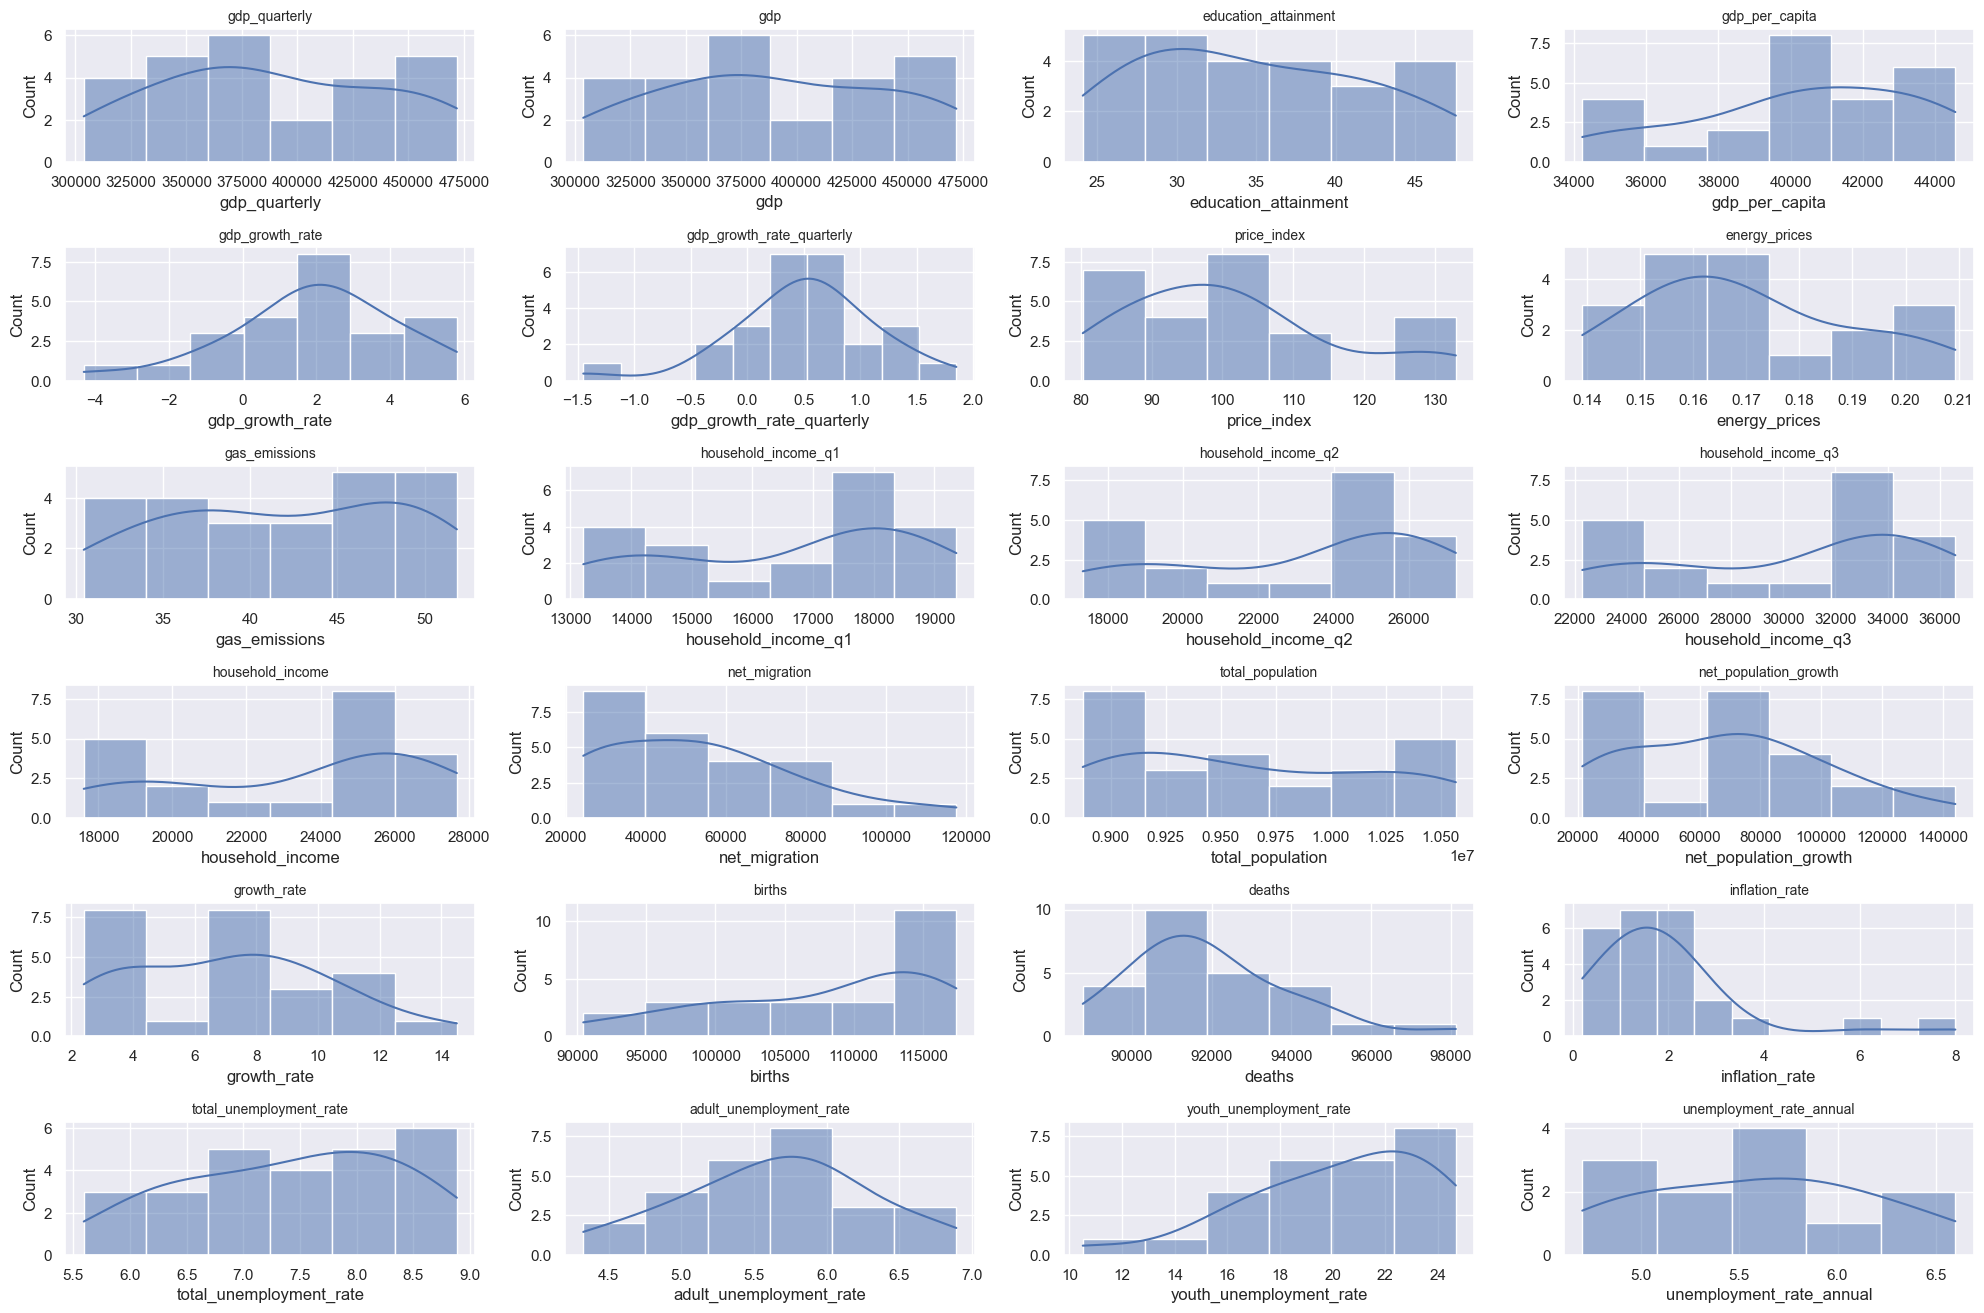

In [19]:
# Histogram plots using kde for distribution visualization
plot_dataframe(df=aggregate_df, plot='hist')

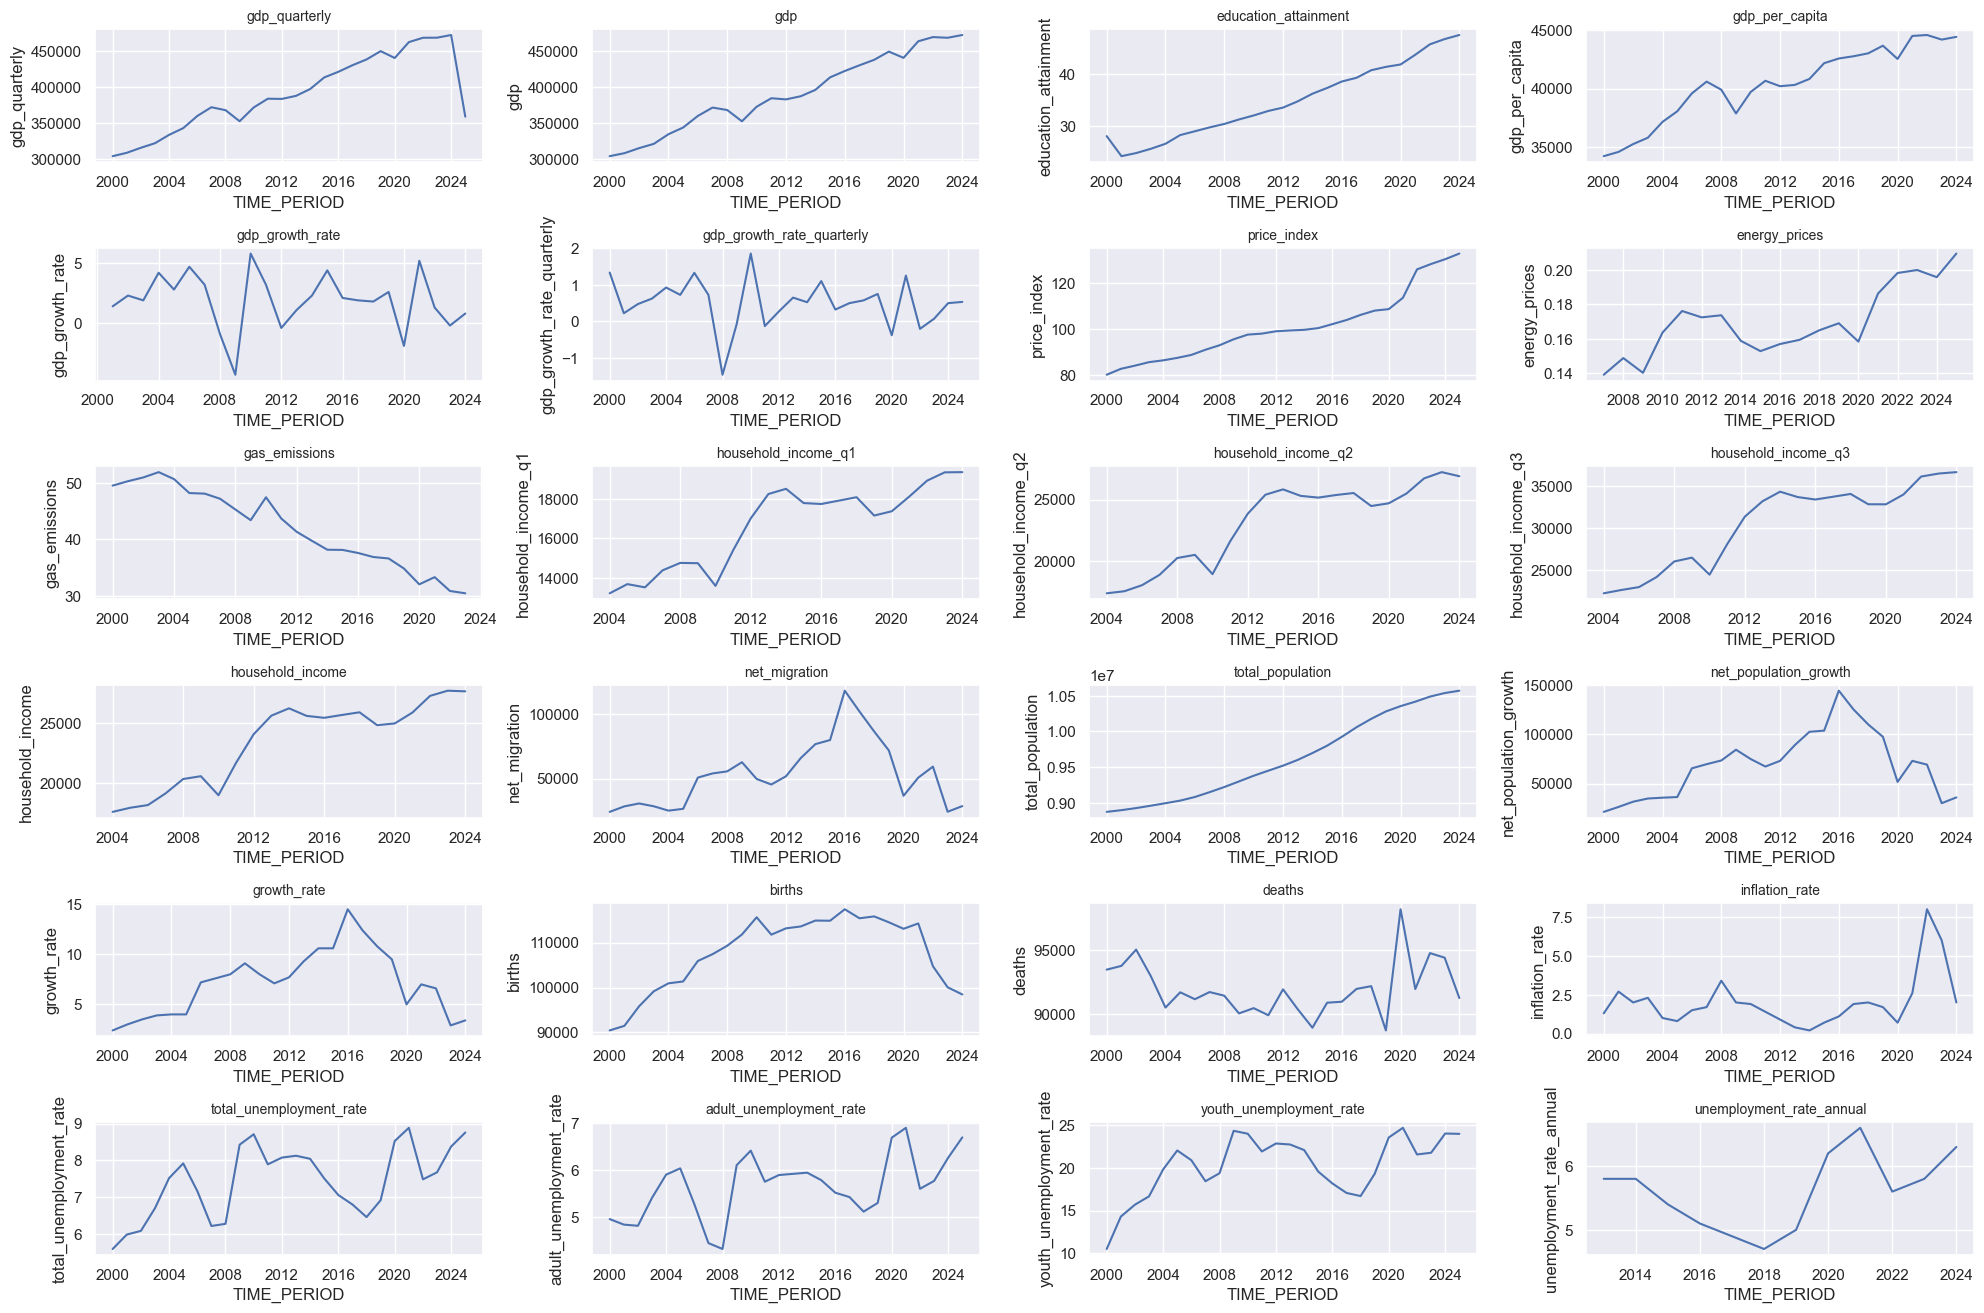

In [20]:
# Line plots to see trends over time
plot_dataframe(df=aggregate_df, plot='line')

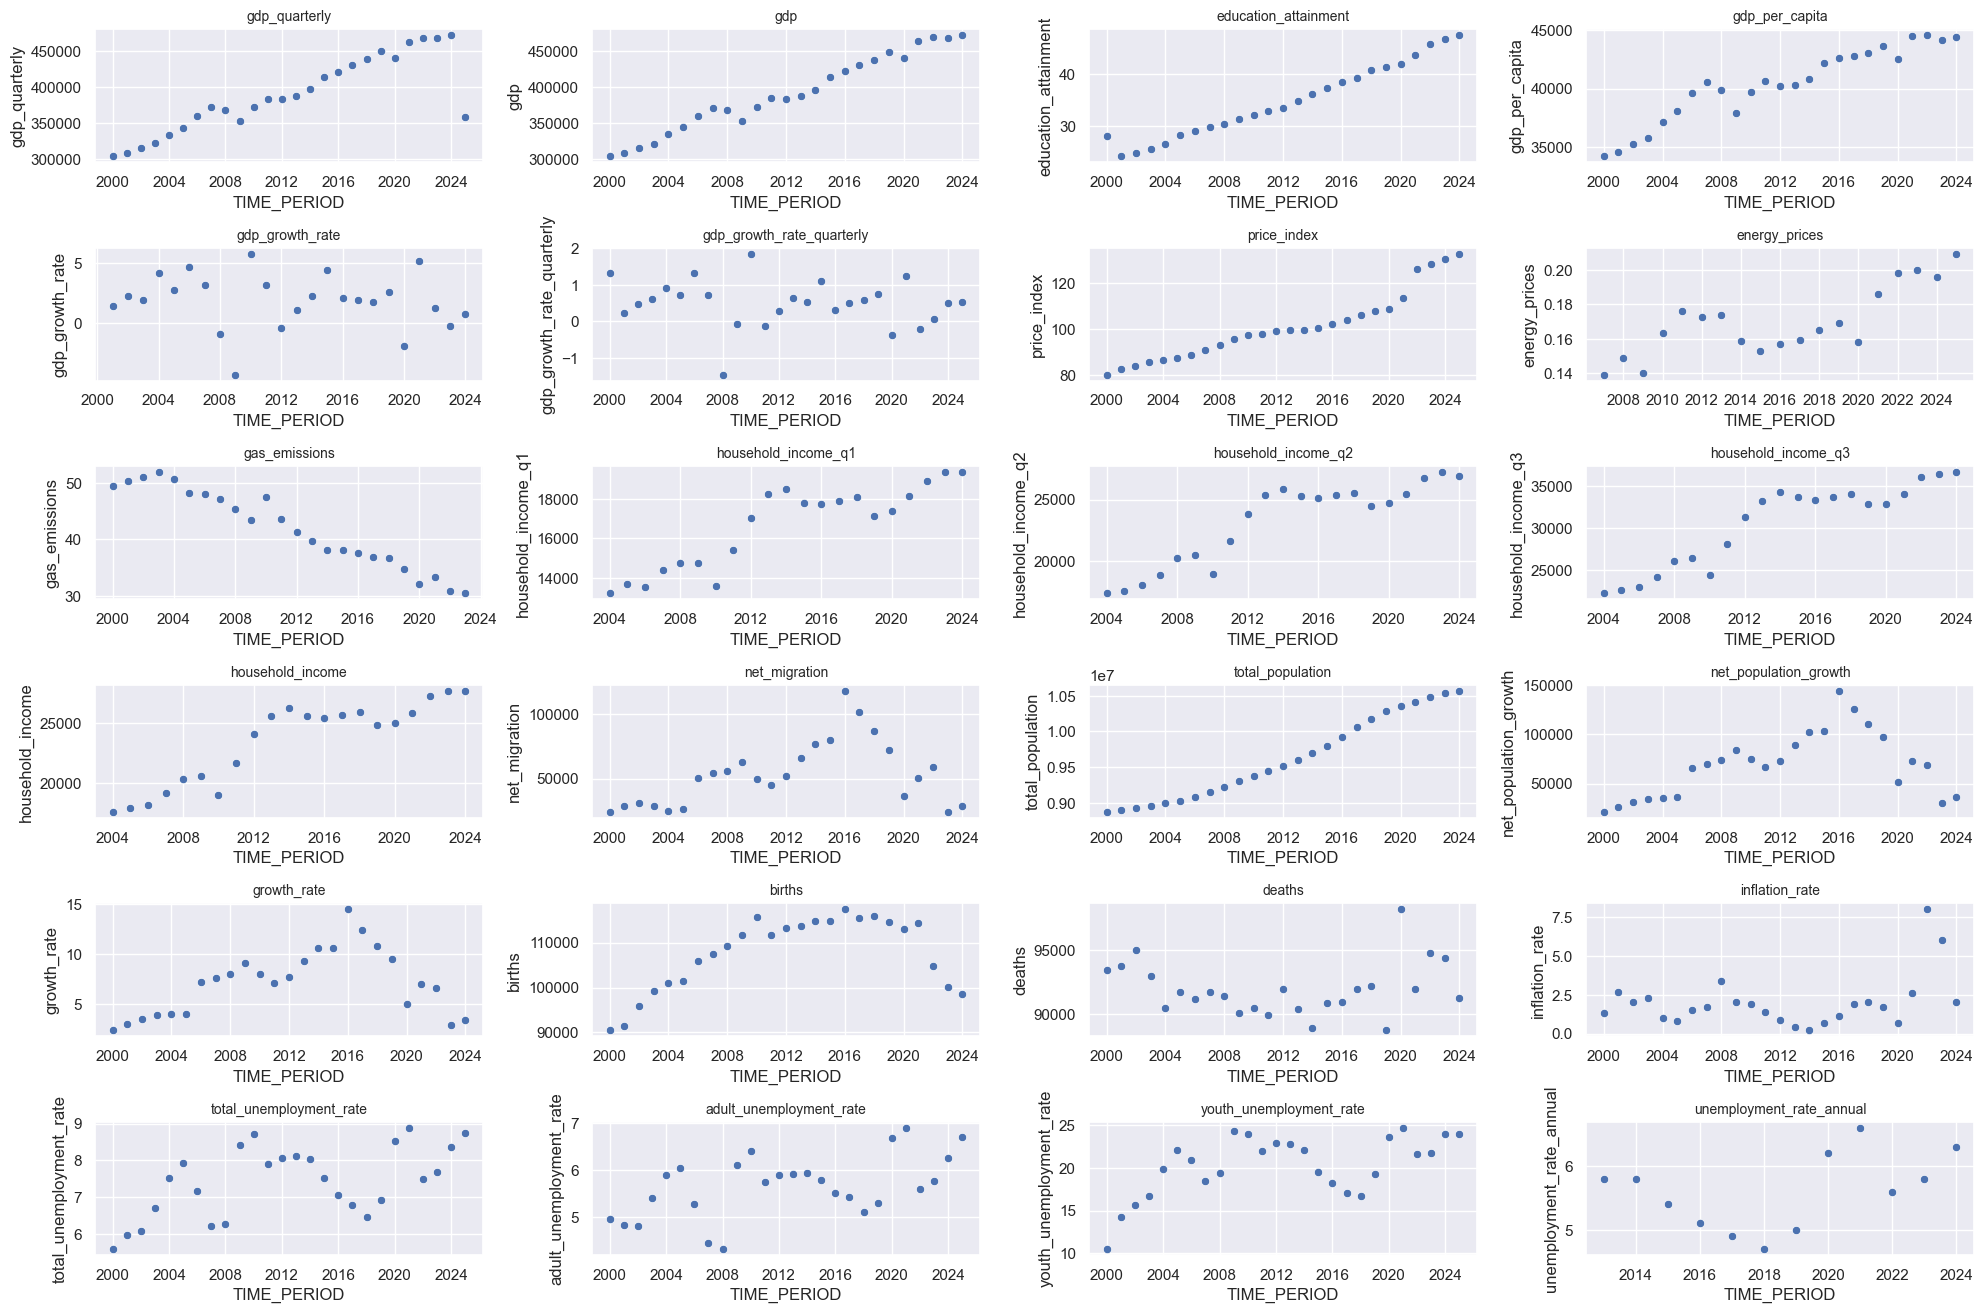

In [21]:
# Scatter plots to see relationships over time and also observations trends
plot_dataframe(df=aggregate_df, plot='scatter')

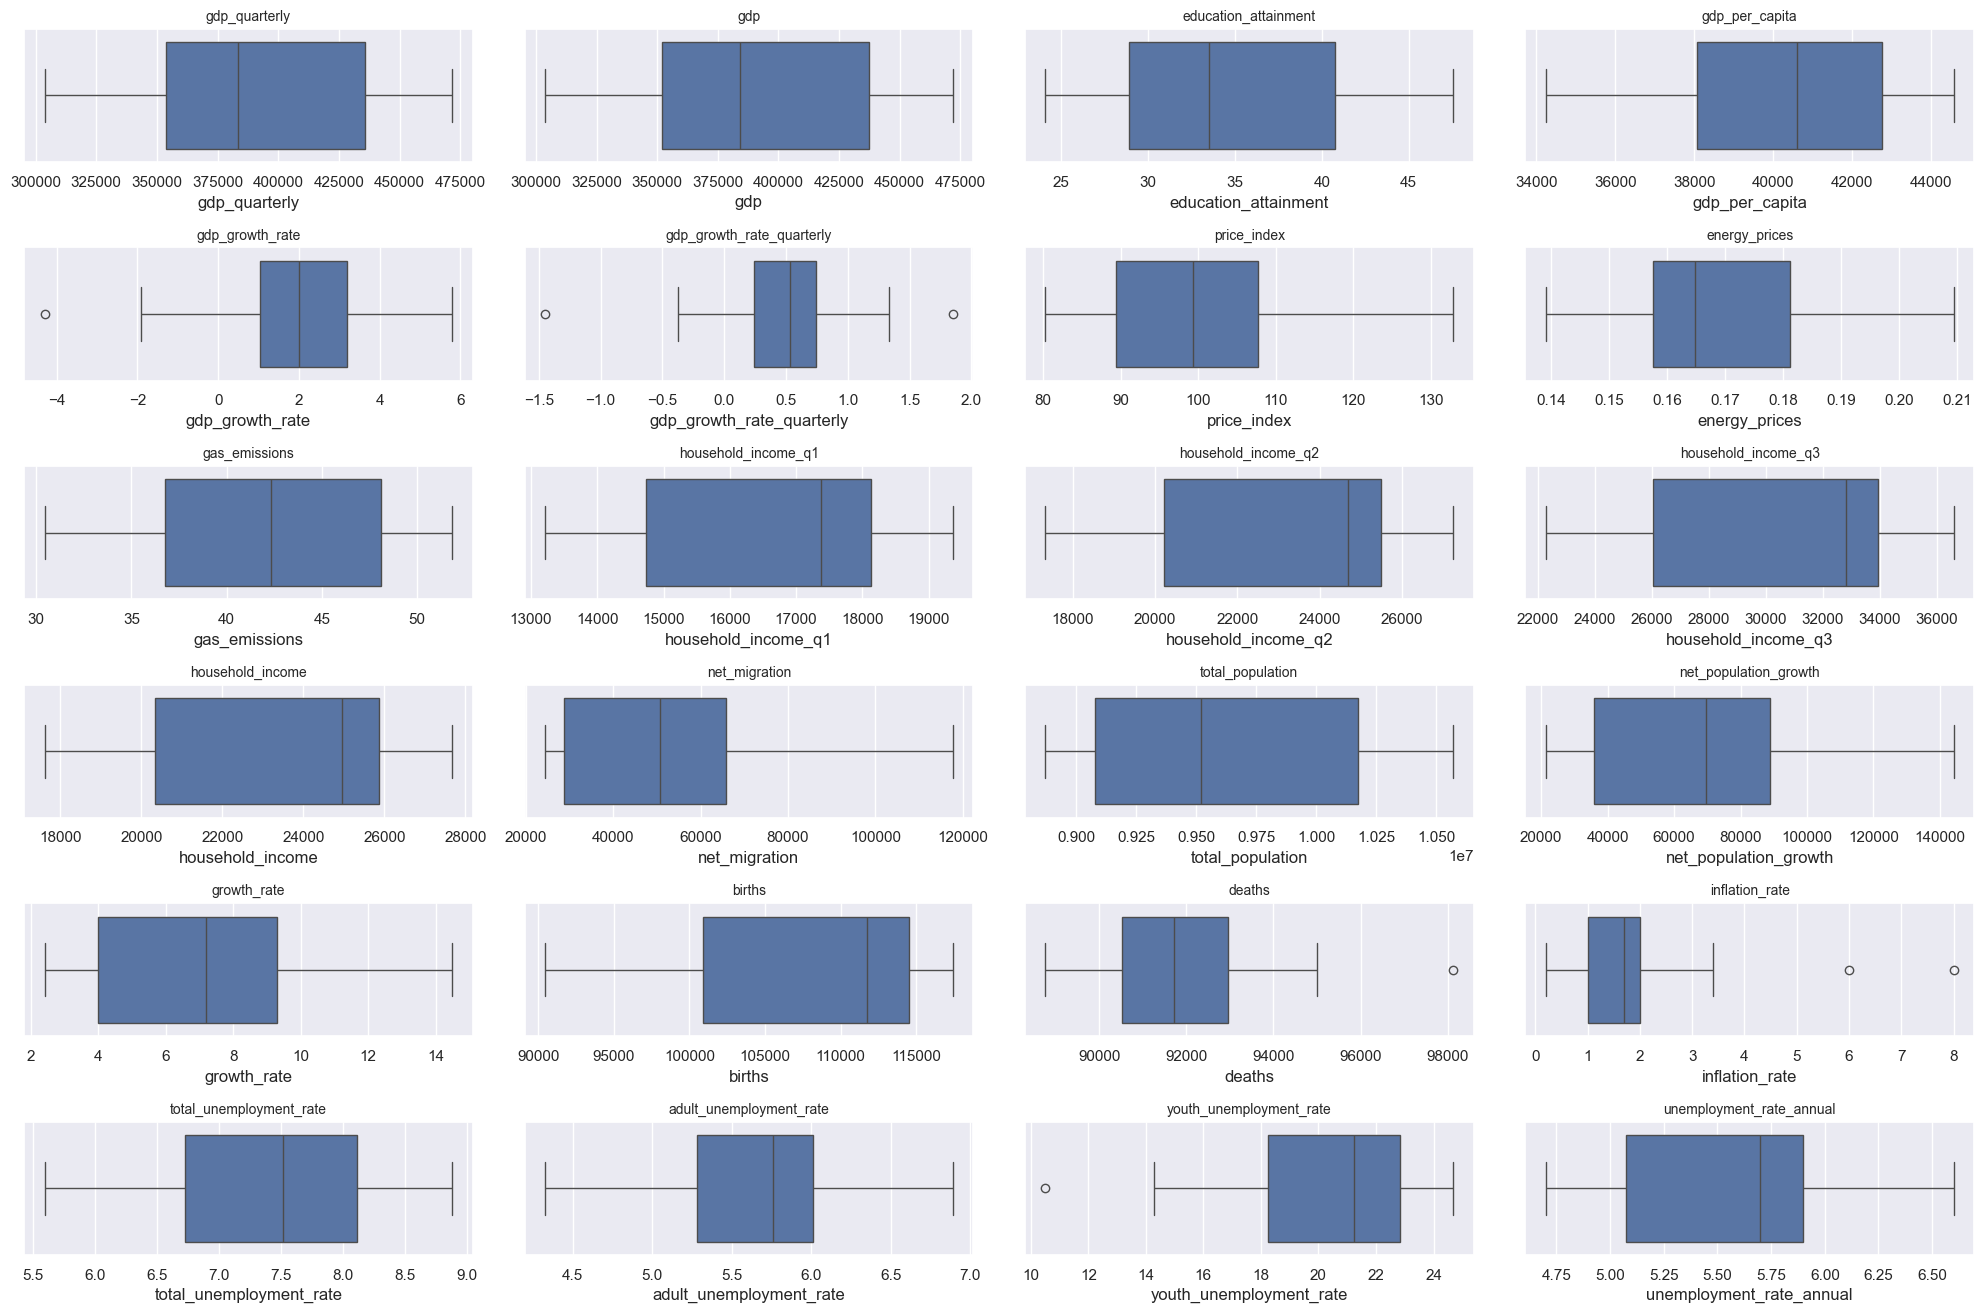

In [22]:
# Box plots to see distributions and outliers
plot_dataframe(df=aggregate_df, plot='box')

#### Bivariate Data

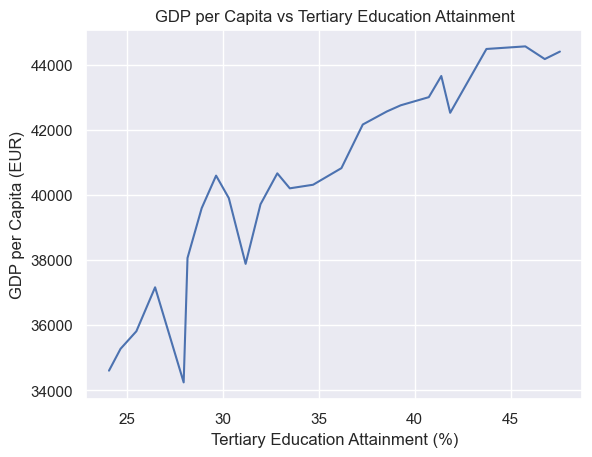

In [23]:
# The relationship between GDP per capita and tertiary education attainment
# The increase in tertiary education attainment correlates with an increase in GDP per capita over time

sns.lineplot(data=aggregate_df, x='education_attainment', y='gdp_per_capita')
plt.title("GDP per Capita vs Tertiary Education Attainment")
plt.xlabel("Tertiary Education Attainment (%)")
plt.ylabel("GDP per Capita (EUR)")
plt.show()

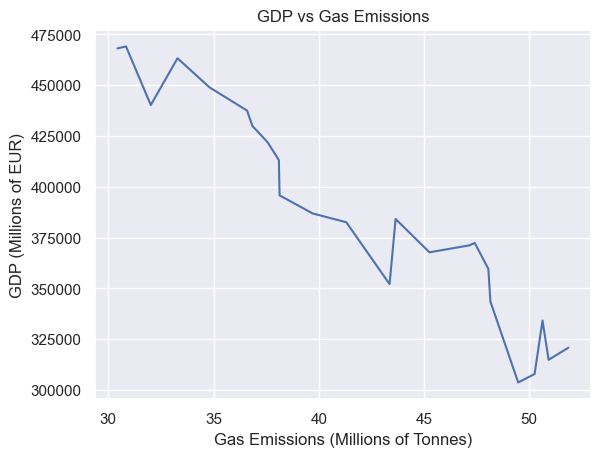

In [24]:
# The relationship between GDP and gas emissions
# A decrease in gas emissions correlates with an increase in GDP over time
sns.lineplot(data=aggregate_df, x='gas_emissions', y='gdp')
plt.title("GDP vs Gas Emissions")
plt.xlabel("Gas Emissions (Millions of Tonnes)")
plt.ylabel("GDP (Millions of EUR)")
plt.show()

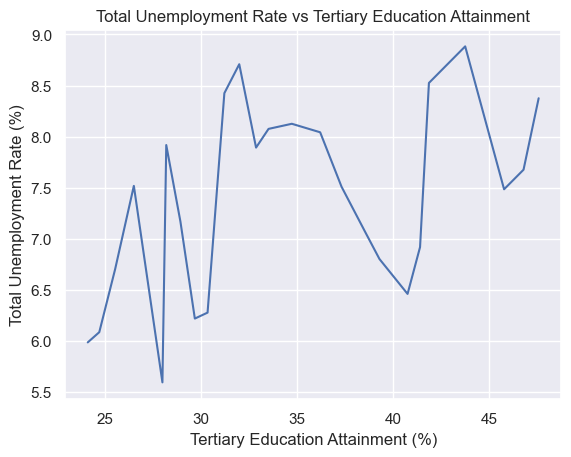

In [25]:
# The relationship between total unemployment rate and tertiary education attainment
# No clear correlation observed
sns.lineplot(data=aggregate_df, x='education_attainment', y='total_unemployment_rate')
plt.title("Total Unemployment Rate vs Tertiary Education Attainment")
plt.xlabel("Tertiary Education Attainment (%)")
plt.ylabel("Total Unemployment Rate (%)")
plt.show()

#### Correlations

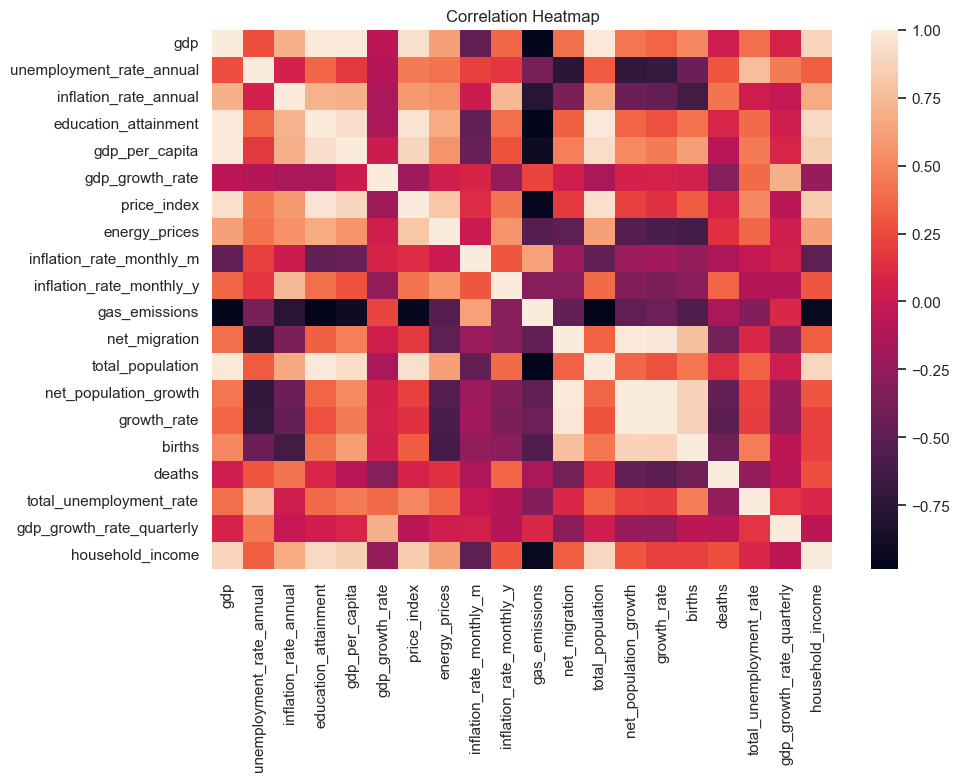

In [26]:
num_df = df.select_dtypes(include='number')
num_df = num_df.drop(columns=[
    'gdp_quarterly', 
    'adult_unemployment_rate', 
    'youth_unemployment_rate',
    'household_income_q1',
    'household_income_q2',
    'household_income_q3',
])
corr_data = num_df.corr()

plt.figure(figsize=(10, 7))
sns.heatmap(data=corr_data, annot=False)
plt.title("Correlation Heatmap")
plt.show()

In [27]:
corr_pairs = (
    corr_data.unstack()
    .sort_values(ascending=False) # type: ignore
    .drop_duplicates()
)
high_corr = corr_pairs[(corr_pairs > 0.9) & (corr_pairs < 1)]
print(high_corr)

net_population_growth  growth_rate             0.995026
total_population       education_attainment    0.990020
net_population_growth  net_migration           0.984034
total_population       gdp                     0.981260
gdp                    gdp_per_capita          0.980233
                       education_attainment    0.980100
growth_rate            net_migration           0.975849
education_attainment   price_index             0.957913
price_index            total_population        0.944813
                       gdp                     0.938076
gdp_per_capita         education_attainment    0.930653
total_population       gdp_per_capita          0.925199
household_income       education_attainment    0.904073
dtype: float64


#### Variance Inflation Factor (VIF)

Data is very correlated, thus multiple columns need to be dropped.

'total_population' - strong positve correlation with - gdp, gdp_per_capita

'gas_emissions' - strong negative correlation with - almost all features

'energy_prices' - weak positive correlation with - 'household_income'

'education_attainment' - strong positive correlation with - 'gdp', 'total_population'

In [28]:
clean_df = pd.DataFrame()
subset = aggregate_df[[
    'gdp_quarterly', 'gdp_growth_rate_quarterly', 
    'inflation_rate', 'total_unemployment_rate',
    'energy_prices', 'household_income',
]]

clean_df = subset.dropna()
clean_df = add_constant(clean_df)

vif_df = pd.DataFrame()
vif_df['features'] = clean_df.columns # pyright: ignore[reportAttributeAccessIssue]
vif_df['VIF'] = [variance_inflation_factor(clean_df.values, i) for i in range(clean_df.shape[1])] # pyright: ignore[reportAttributeAccessIssue]

vif_df.sort_values(by="VIF", ascending=False)

,features,VIF
0,const,228.936838
1,gdp_quarterly,4.843886
6,household_income,4.060317
5,energy_prices,4.046218
3,inflation_rate,2.488842
4,total_unemployment_rate,1.605613
2,gdp_growth_rate_quarterly,1.361202
